In [6]:
from astro.load import Loader, GroupSessionData
from astro.preprocess import Preprocessor, GroupedEventPreprocessor
from astro.transforms import GroupSplitter


from trace_minder.preprocess import TracePreprocessor
from trace_minder.align import GroupedAligner
from trace_minder.surrogates import SurrogateTemplate, Rotater, TraceSampler
from trace_minder.trace_aggregation import PrePostAggregator
from trace_minder.responders.rotated_responder import AUCDiff, AUCDiffResponders


from dataclasses import dataclass
from typing import Generator, Callable
import pandas as pd
from astro.decoding_alltime.runner import RunResults
import numpy as np

import os
from pathlib import Path
from astro.config import Config

#### Paths

In [7]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.parent
env_path = root_path / ".env"

paths = Config.from_env(env_path)

#### Config

- Loading and preprocessing of traces and events
- 'Group' information to account for different mice having different block onsets
- Alignment configuration
- Post alignment processing, if any
- Configuration of the AUC calculater
- Configuration of the AUC bootstrap tester

In [8]:
loader = Loader(data_dir=paths.data_dir)

loader_preprocessor_first5 = Preprocessor(
    trace_preprocessor=TracePreprocessor(
        max_time=600,
        standardize=True,
        medfilt_kernel_size=None,
        resample_frequency=0.1,
        drop_na=True,
    ),
    grouped_event_preprocessor=GroupedEventPreprocessor(
        df_events_group_col="mouse_name",
        df_events_event_time_col="start_time",
        first_x_events=5,
    ),
)
loader.preprocessor = loader_preprocessor_first5


group_splitter = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    df_traces_time_col="time",
    excluded_groups=["VEH-VEH"],
    df_neurons_mouse_col="mouse_name",
    df_mice_mouse_col="mouse_name",
    df_neurons_neuron_col="cell_id",
    df_mice_group_col="group",
)

aligner = GroupedAligner(
    t_before=30,
    t_after=30,
    df_wide_group_mapper=group_splitter.neurons_by_mouse(),
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
    round_precision=1,
)

average_trace_preprocessor = TracePreprocessor()

aggregator = PrePostAggregator(event_idx_col=None)


stat_calculator = AUCDiff(
    aligner=aligner,
    average_trace_preprocessor=average_trace_preprocessor,
    aggregator=aggregator,
)

responders_calculator = AUCDiffResponders(
    aligner=aligner,
    average_trace_preprocessor=average_trace_preprocessor,
    aggregator=aggregator,
    n_boot=50,
    _store_reps=True,
)

#### Examplar: Calculating the Observed Statistic


- Traces and events start times are loaded from a single session for each mouse
- The `AUCDiff` AUC calculater performs the following steps automatically:
  - Traces are aligned to events, calculating an average trace over trials
  - AUC is calculated for the pre and post sections of the average trace


In [9]:
df_traces = loader.load_traces(session_name="ret")
df_events = loader.load_blockstarts(session_name="ret", block_group="CS")


print("Average trace (long)")
df_average_trace = aligner.average_trace_long(df_traces, event_starts=df_events)
display(df_average_trace.head(3))


print()
print("Statistic: AUC-post minus AUC-pre")
df_auc_diff = aggregator.prepost_diff(df_average_trace)
display(df_auc_diff.head(3))


# stat calculater
print()
print("---------------------------")
print("Statistic calculator")
print("---------------------------")
stat_calculator.get_stat(df_traces, df_events).head(3)

Average trace (long)


,aligned_time,neuron,value
0,-30.0,1050,-0.141333
1,-29.9,1050,-0.014349
2,-29.8,1050,-0.063068



Statistic: AUC-post minus AUC-pre


,event_idx,neuron,post,pre,post_sub_pre
0,0,1050,0.015355,-0.079142,0.094497
1,0,1051,0.512359,0.215746,0.296614
2,0,1053,-0.105208,0.001938,-0.107147



---------------------------
Statistic calculator
---------------------------


,event_idx,cell_id,post,pre,auc_diff
0,0,1050,0.015355,-0.079142,0.094497
1,0,1051,0.512359,0.215746,0.296614
2,0,1053,-0.105208,0.001938,-0.107147


#### Exemplar: Computing responders using a bootstrap test

- Traces and events are loaded for each mice for a single session
- The `AUCDiffResponders` class calulates the following
  - Once, calculates the AUC difference statistic on the observed data
  - For each bootstrap iteration, rotates the traces, and calculates the AUC difference statistic
  - Calculates p-values for each cell by comparing the observed statistic to the bootstrap distribution

In [10]:
responders = responders_calculator.get_responders(df_traces, df_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Columns: 906 entries, time to 984
dtypes: float64(906)
memory usage: 41.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mouse_name   120 non-null    object 
 1   block_name   0 non-null      object 
 2   block_group  120 non-null    object 
 3   start_time   120 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.9+ KB
None
        aligned_time neuron     value
0              -30.0   1050 -0.141333
1              -29.9   1050 -0.014349
2              -29.8   1050 -0.063068
3              -29.7   1050  0.055429
4              -29.6   1050 -0.090560
...              ...    ...       ...
399660          29.6    881  0.270566
399661          29.7    881  0.277736
399662          29.8    881  0.214655
399663          29.9    881  0.161440
399664       

In [10]:
print("---------------------------")
print("DF OBSERVED")
print("---------------------------")
display(responders_calculator.df_obs_.head(3))

print("---------------------------")
print("DF BOOTSTRAP REPLICATES")
print("---------------------------")
display(responders_calculator.df_bootreps_.head(3))


print("---------------------------")
print("DF RESPONDERS")
print("---------------------------")
display(responders_calculator.df_responders_.head(3))

---------------------------
DF OBSERVED
---------------------------


,cell_id,stat
0,1050,0.094660
1,1051,0.274679
2,1053,-0.082772


---------------------------
DF BOOTSTRAP REPLICATES
---------------------------


,cell_id,stat,sample
0,1050,-0.084643,0
0,1050,-0.272043,1
0,1050,0.203092,2


---------------------------
DF RESPONDERS
---------------------------


,cell_id,stat,pval,sig
0,1050,0.094660,1.84,False
1,1051,0.274679,1.12,False
2,1053,-0.082772,1.40,False


In [ ]:
from typing import Optional


class RespondersSaver:
    def __init__(
        self,
        root_data_dir: Path,
        responders_fn: bool = "responders.csv",
        reps_fn: Optional[str] = "responders_reps.parquet",
        aligned_fn: Optional[str] = "aligned_traces.parquet",
        compression: Optional[str] = "snappy",
    ):
        self.root_data_dir = root_data_dir
        self.responders_fn = responders_fn
        self.reps_fn = reps_fn
        self.aligned_fn = aligned_fn
        self.compression = compression
        self.save_dir_ = None

    def _get_save_dir(self, name: Optional[str] = None):
        match name:
            case None:
                self.save_dir_ = self.root_data_dir
            case _:
                self.save_dir_ = self.root_data_dir / name

        self.save_dir_.mkdir(exist_ok=True)
        return self.save_dir_

    def save(
        self,
        df_responders: pd.DataFrame,
        name: Optional[str] = None,
        df_aligned: Optional[pd.DataFrame] = None,
    ):
        save_dir = self._get_save_dir(name)
        df_responders.to_csv(save_dir / self.responders_fn, index=False)

        if df_aligned is not None and self.aligned_fn is not None:
            df_aligned.to_parquet(
                save_dir / self.aligned_fn, index=False, compression=self.compression
            )
        if self.reps_fn is not None and self.reps_fn is not None:
            self.save_reps(df_responders, name=name)


from dataclasses import dataclass


@dataclass
class RespondersConfig:
    loader_preprocessor: Preprocessor
    aligner: GroupedAligner
    average_trace_preprocessor: TracePreprocessor
    aggregator: PrePostAggregator
    n_boot: int = 50


def run_responders(
    name: str,
    loader: Loader,
    responders_config: RespondersConfig,
    saver: Optional[RespondersSaver] = None,
):
    store_reps = True if saver is not None else False

    df_traces = loader.load_traces()
    df_events = loader.load_blockstarts()

    responders_calculator = AUCDiffResponders(
        aligner=responders_config.aligner,
        average_trace_preprocessor=responders_config.average_trace_preprocessor,
        aggregator=responders_config.aggregator,
        n_boot=responders_config.n_boot,
        _store_reps=store_reps,
    )
    df_responders = responders_calculator.get_responders(df_traces, df_events)

    if saver is not None:
        saver.save(df_responders, name=name, df_aligned=df_responders)

In [ ]:
def run_responders(
        loader: Loader,
        responders_config: RespondersConfig,
):

<Axes: >

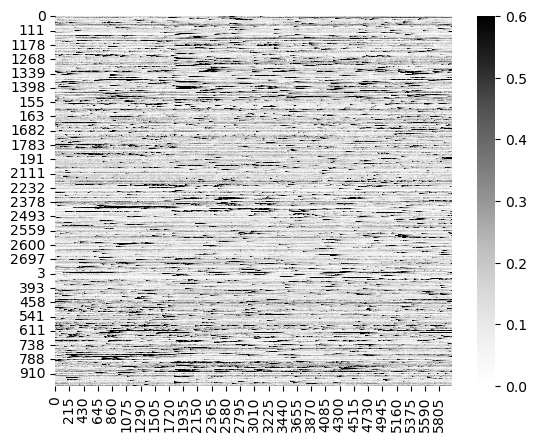

In [162]:
import seaborn as sns
from sklearn.preprocessing import minmax_scale


sns.heatmap(
    df_traces.drop("time", axis=1).transform(minmax_scale).T,
    cmap="Greys",
    vmin=0,
    vmax=0.6,
)

<Axes: >

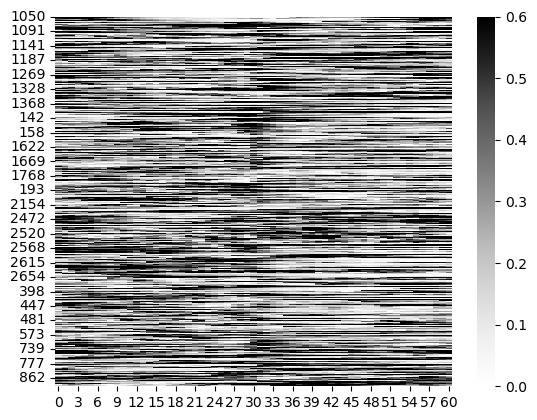

In [163]:
dfp = aligner.average_trace(df_traces, df_events)

sns.heatmap(
    dfp.drop("aligned_time", axis=1).transform(minmax_scale).T,
    cmap="Greys",
    vmin=0,
    vmax=0.6,
)